In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns


# 데이터 로드
df_ab = pd.read_csv('../data/ab_data.csv')
df_ct = pd.read_csv('../data/countries.csv')

# 데이터 합치기
df = pd.merge(df_ab, df_ct, on='user_id', how='left')
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294482 entries, 0 to 294481
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294482 non-null  int64 
 1   timestamp     294482 non-null  object
 2   group         294482 non-null  object
 3   landing_page  294482 non-null  object
 4   converted     294482 non-null  int64 
 5   country       294482 non-null  object
dtypes: int64(2), object(4)
memory usage: 13.5+ MB


(   user_id timestamp      group landing_page  converted country
 0   851104   11:48.6    control     old_page          0      US
 1   804228   01:45.2    control     old_page          0      US
 2   661590   55:06.2  treatment     new_page          0      US
 3   853541   28:03.1  treatment     new_page          0      US
 4   864975   52:26.2    control     old_page          1      US,
 None)

In [2]:
# 1. 그룹별 전환 수와 전체 수 계산
summary = df.groupby('group')['converted'].agg(['sum', 'count']).rename(columns={'sum': 'conversions', 'count': 'total'})
print("🔍 전환 요약:\n", summary)


🔍 전환 요약:
            conversions   total
group                         
control          17723  147202
treatment        17514  147280


In [3]:
# 2. Z-test for proportions (전환율 비교)
count = summary['conversions'].values  # 성공 수
nobs = summary['total'].values         # 전체 수

z_stat, p_value = proportions_ztest(count, nobs)
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("✅ 통계적으로 유의미한 차이가 있습니다.")
else:
    print("❌ 유의미한 차이는 없습니다.")


Z-statistic: 1.2396
P-value: 0.2151
❌ 유의미한 차이는 없습니다.


In [4]:
# 3. Chi-squared test (독립성 검정)
contingency = pd.crosstab(df['group'], df['converted'])
chi2, p_chi, _, _ = chi2_contingency(contingency)

print(f"\nChi-squared: {chi2:.4f}")
print(f"Chi-squared P-value: {p_chi:.4f}")



Chi-squared: 1.5227
Chi-squared P-value: 0.2172


In [5]:
# 4. 효과 크기 계산 (Cohen's h)
from math import asin, sqrt

p1 = count[0] / nobs[0]
p2 = count[1] / nobs[1]
cohen_h = 2 * (asin(sqrt(p1)) - asin(sqrt(p2)))

if abs(cohen_h) < 0.2:
    interpret = '매우 작은 효과'
elif abs(cohen_h) < 0.5:
    interpret = '작은 효과'
elif abs(cohen_h) < 0.8:
    interpret = '중간 정도 효과'
else:
    interpret = '큰 효과'
    
print(f"\nCohen's h (효과 크기): {cohen_h:.4f}")
print(f"📏 효과 크기 해석: {interpret}")



Cohen's h (효과 크기): 0.0046
📏 효과 크기 해석: 매우 작은 효과


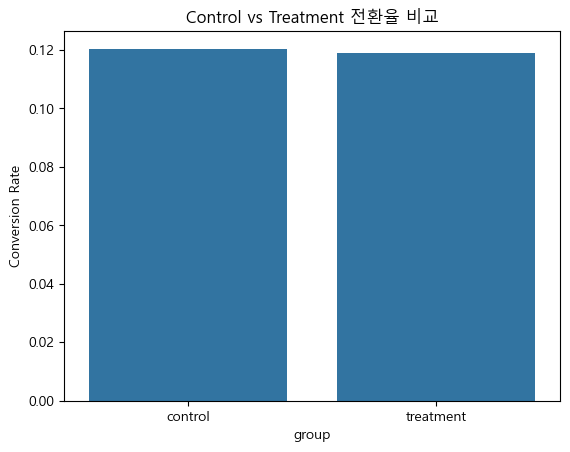

In [6]:
# 5. 시각화 - 전환율 차이 시각화

import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 깨짐 방지 설정
mpl.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용자용
mpl.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 깨짐 방지

### 위까진 폰트 내용임 ###

summary['conversion_rate'] = summary['conversions'] / summary['total']
summary.reset_index(inplace=True)

sns.barplot(data=summary, x='group', y='conversion_rate')
plt.title('Control vs Treatment 전환율 비교')
plt.ylabel('Conversion Rate')
plt.savefig('../outputs/figures/7_conversion_rate_comparison.png')
plt.show()


In [7]:
import statsmodels.api as sm

ci_low, ci_upp = sm.stats.proportion_confint(count, nobs, alpha=0.05, method='normal')
print(f"신뢰구간(Control): [{ci_low[0]:.4f}, {ci_upp[0]:.4f}]")
print(f"신뢰구간(Treatment): [{ci_low[1]:.4f}, {ci_upp[1]:.4f}]")


신뢰구간(Control): [0.1187, 0.1221]
신뢰구간(Treatment): [0.1173, 0.1206]
